## INFRASTRUCTURE

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpmath import mp, nsum, exp, binomial, fac, fdot, log
from tqdm import tqdm
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D


# Set the precision (number of decimal places)
mp.dps = 50

### Defining individual $e_j$, $U^n_j$, $D^n_j = V^n_j - U^n_j$ values and rows of $W^n_{b, j}$ per $b$:

In [2]:
def calculate_e_j(j, tau, psi, phi, a, b):
    """
    Calculate the value of e_j given the time parameters tau, psi, phi
    and population ratio parameters a, b.
    """
    j_choose_2 = mp.mpf(binomial(j, 2))

    tau = mp.mpf(tau)
    psi = mp.mpf(psi)
    phi = mp.mpf(phi)
    a = mp.mpf(a)
    b = mp.mpf(b)

    term1 = exp(-j_choose_2 * tau) * (
        (j_choose_2**(-1) * exp(j_choose_2 * tau)) - (j_choose_2**(-1)) +
        ((b/a) * (j_choose_2**(-1))) - exp(-(a/b) * j_choose_2 * psi) *
        (((b/a) * (j_choose_2**(-1))) + tau + psi)
    )
    
    term2 = exp(-j_choose_2 * (a/b) * psi) * exp(-j_choose_2 * tau) * (
        ((1/a) * (j_choose_2**(-1))) + tau + psi -
        exp(-a * j_choose_2 * phi) * (((1/a) * (j_choose_2**(-1))) + tau + psi + phi)
    )
    
    term3 = exp(-j_choose_2 * (tau + (a/b) * psi + a * phi)) * (tau + psi + phi)
    
    e_j = term1 + term2 + term3
    
    return e_j

In [3]:
def calculate_U_n_j(n, j):
    """
    Calculate the constant U^n_j for given n and j.
    """
    U_n_j = (2 * j - 1) * (fac(n) * fac(n - 1)) / (fac(n + j - 1) * fac(n - j)) * (-1)**j
    return U_n_j

In [4]:
def calculate_D_n_j(n, j):
    """
    Calculate the constant D^n_j = V^n_j - U^n_j for given n and j.
    """
    D_n_j = (2 * j - 1) * (fac(n) * fac(n - 1)) / (fac(n + j - 1) * fac(n - j))
    return D_n_j

In [5]:
def calculate_W_n_b_j(n, b):
    """
    Calculate a row of W^n_b,j given n and b.
    """
    # Initialize the array with zeros for all j from 2 to n
    W_n_b_j = [mp.mpf(0) for _ in range(2, n+1)]
    
    # Base case for j=2
    W_n_b_j[0] = mp.mpf(6) / (n + 1)
    
    # Check for n greater than 1 to calculate W^n_b,3
    if n > 1:
        W_n_b_j[1] = mp.mpf(30) * (n - 2 * b) / ((n + 1) * (n + 2))
    
    # Recursive calculation for j from 4 to n (j+2 in the original formula)
    for j in range(2, n-1):
        W_n_b_j[j] = mp.mpf(-((1 + j) * (3 + 2 * j) * (n - j)) / (j * (2 * j - 1) * (n + j + 1))) * W_n_b_j[j-2] \
                    + mp.mpf(((3 + 2 * j) * (n - 2 * b)) / (j * (n + j + 1))) * W_n_b_j[j-1]
    
    return W_n_b_j

### Defining functions to pre-compute $e_j$, $U^n_j$, $D^n_j = V^n_j - U^n_j$ and $W^n_{b, j}$:

In [6]:
def precompute_all_e_j_values(n, tau, psi, phi, a, b):
    """
    Pre-compute all e_j values for j from 2 to n using the calculate_e_j function.
    """
    e_j_values = [calculate_e_j(j, tau, psi, phi, a, b) for j in range(2, n+1)]
    
    return e_j_values

In [7]:
def precompute_U_n_j_values(n):
    """
    Pre-compute all U^n_j values for j from 2 to n.
    """
    U_n_j_values = [calculate_U_n_j(n, j) for j in range(2, n+1)]
    return U_n_j_values

In [8]:
def precompute_D_n_j_values(n):
    """
    Pre-compute all D^n_j values for j from 2 to n.
    """
    D_n_j_values = [calculate_D_n_j(n, j) for j in range(2, n+1)]
    return D_n_j_values


In [9]:
def precompute_W_n_b_j_matrix(n):
    """
    Pre-compute the 2-dimensional matrix W^n_b,j for b from 1 to n-1 inclusively,
    and print the dimension of the pre-computed matrix.
    """
    # Initialize the matrix to store W^n_b,j values for each b from 1 to n-1
    W_n_b_j_matrix = [calculate_W_n_b_j(n, b) for b in range(1, n)]
    
    # Print the dimensions of the pre-computed matrix
    matrix_rows = len(W_n_b_j_matrix)
    matrix_columns = len(W_n_b_j_matrix[0])
    #print(f"Dimensions of the pre-computed W^n_b,j matrix: {matrix_rows} rows x {matrix_columns} columns with n = {n}")
    
    return W_n_b_j_matrix

### Defining function to compute the vector $q_{n,b}$ (normalised so the vector sums to 1):

In [10]:
def calculate_q_n_b(n, e_j_values, U_n_j_values, D_n_j_values, W_n_b_j_matrix, tau, psi, phi, absolute = False):
    """
    Calculate the values of q_n,b given n, b, pre-computed arrays and matrix, and time parameters.
    """

    # Calculate total time T_tot
    T_tot = tau + psi + phi
    
    # Initialize an array to store q_n,b values
    q_n_b = mp.zeros(n, 1)  # For b from 1 to n-1
    
    # Calculate q_n,b for b from 1 to n
    for k in range(1, n+1):
        if k < n:
            numerator = fdot(e_j_values, W_n_b_j_matrix[k-1])
        else:  # For b = n
            numerator = T_tot - fdot(e_j_values, U_n_j_values)

        denominator = T_tot + fdot(e_j_values, D_n_j_values)

        q_n_b[k-1] = numerator / denominator

    if absolute:
        q_n_b[n-1] = T_tot - fdot(e_j_values, U_n_j_values)
    
    return q_n_b

### Conversion from proper time to scaled time:

In [11]:
def proper_to_scaled_time(t_proper_years, n, t_half=30):
    """
    Convert proper time in years to scaled time for coalescent processes.
    
    Parameters:
    - t_proper_years: Proper time in years.
    - n: Population size at the time of sampling.
    - t_half: Half-life of mtDNA in days (default is 30 days).
    
    Returns:
    - t_scaled: Scaled time.
    """
    # Convert proper time from years to days
    t_proper_days = t_proper_years * 365
    
    # Calculate scaled time
    t_scaled = (2 * log(2) / (n * t_half)) * t_proper_days
    
    return t_scaled

## ANALYSIS

### Total age $= 100$ years; $N_W \text{ (pop. at birth)} = 500; N_0 = a N_W$

In [63]:
age = 10
n_w = 500

### Plotting SFS for an example regime:

In [64]:
a = 1
b = 1
tau_proper_years = 1  # Proper time for tau in years
psi_proper_years = 1 # Proper time for psi in years
phi_proper_years = age - tau_proper_years - psi_proper_years  # Proper time for phi in years
t_half = 30  # Half-life of mtDNA in days
n = n_w * a

# Convert proper times to scaled times
tau = proper_to_scaled_time(tau_proper_years, n, t_half)
psi = proper_to_scaled_time(psi_proper_years, n*b, t_half)
phi = proper_to_scaled_time(phi_proper_years, n, t_half)

# 1. Pre-compute e_j_values
e_j_values = precompute_all_e_j_values(n, tau, psi, phi, a, b)

# 2. Pre-compute U_n_j_values
U_n_j_values = [calculate_U_n_j(n, j) for j in range(2, n+1)]

# 3. Pre-compute D_n_j_values
D_n_j_values = [calculate_D_n_j(n, j) for j in range(2, n+1)]

# 4. Pre-compute W_n_b_j_matrix for b from 1 to n-1
W_n_b_j_matrix = [calculate_W_n_b_j(n, b_val) for b_val in range(1, n)]

# 5. Calculate the vector q_n, b for b from 1 to n-1
q_n_b = calculate_q_n_b(n, e_j_values, U_n_j_values, D_n_j_values, W_n_b_j_matrix, tau, psi, phi, absolute=False)

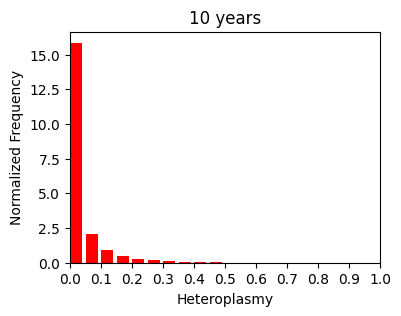

In [65]:
# Convert q_n_b's entries to represent the SFS, scaled up by n
scaled_sfs = np.array([float(val) * n for val in q_n_b])
heteroplasmy_ratios = np.array(range(1, n + 1)) / n

# Define bin edges for plotting with a bin width of 0.05
new_bin_width = 0.05
new_bin_edges = np.arange(0, 1 + new_bin_width, new_bin_width)

# Initialize an array to hold the new averaged frequencies
averaged_sfs = np.zeros(len(new_bin_edges) - 1)

# Aggregate the original frequencies into the new bins
for i in range(len(averaged_sfs)):
    # Determine the start and end of the current bin
    bin_start = new_bin_edges[i]
    bin_end = new_bin_edges[i + 1]
    
    # Calculate the average frequency for heteroplasmy levels within the current bin
    indices = np.where((heteroplasmy_ratios > bin_start) & (heteroplasmy_ratios <= bin_end))[0]
    averaged_sfs[i] = np.mean(scaled_sfs[indices]) if len(indices) > 0 else 0

# Plot the new histogram with bins of width 0.05
plt.figure(figsize=(4, 3))
plt.bar(new_bin_edges[:-1], averaged_sfs, width=new_bin_width*0.8, align='edge', color='red')
plt.xlabel('Heteroplasmy')
plt.ylabel('Normalized Frequency')
plt.title(r'10 years')
plt.xticks(np.arange(0, 1.1, 0.1))
plt.xlim(0, 1)
#plt.ylim(0, max(averaged_sfs)*1.1)  # Adjust y-axis limit to fit the max frequency
#plt.ylim(0, 16)
plt.show()

In [98]:
N_eff = 1 / ( (tau/(tau+psi+phi))/(500) + (psi/(tau+psi+phi))/(1000) + (phi/(tau+psi+phi))/(500))
N_eff

mpf('548.38709677419354838709677419354838709677419354838683')

In [99]:
a = 1
b = 1
tau_proper_years = 10  # Proper time for tau in years
psi_proper_years = 30 # Proper time for psi in years
phi_proper_years = age - tau_proper_years - psi_proper_years  # Proper time for phi in years
t_half = 30  # Half-life of mtDNA in days
n = int(N_eff)

# Convert proper times to scaled times
tau = proper_to_scaled_time(tau_proper_years, n, t_half)
psi = proper_to_scaled_time(psi_proper_years, n*b, t_half)
phi = proper_to_scaled_time(phi_proper_years, n, t_half)

# 1. Pre-compute e_j_values
e_j_values = precompute_all_e_j_values(n, tau, psi, phi, a, b)

# 2. Pre-compute U_n_j_values
U_n_j_values = [calculate_U_n_j(n, j) for j in range(2, n+1)]

# 3. Pre-compute D_n_j_values
D_n_j_values = [calculate_D_n_j(n, j) for j in range(2, n+1)]

# 4. Pre-compute W_n_b_j_matrix for b from 1 to n-1
W_n_b_j_matrix = [calculate_W_n_b_j(n, b_val) for b_val in range(1, n)]

# 5. Calculate the vector q_n, b for b from 1 to n-1
q_n_b = calculate_q_n_b(n, e_j_values, U_n_j_values, D_n_j_values, W_n_b_j_matrix, tau, psi, phi, absolute=False)

# Convert q_n_b's entries to represent the SFS, scaled up by n
scaled_sfs = np.array([float(val) * n for val in q_n_b])
heteroplasmy_ratios = np.array(range(1, n + 1)) / n

# Define bin edges for plotting with a bin width of 0.05
new_bin_width = 0.025
new_bin_edges = np.arange(0, 1 + new_bin_width, new_bin_width)

# Initialize an array to hold the new averaged frequencies
averaged_sfs_n = np.zeros(len(new_bin_edges) - 1)

# Aggregate the original frequencies into the new bins
for i in range(len(averaged_sfs_n)):
    # Determine the start and end of the current bin
    bin_start = new_bin_edges[i]
    bin_end = new_bin_edges[i + 1]
    
    # Calculate the average frequency for heteroplasmy levels within the current bin
    indices = np.where((heteroplasmy_ratios > bin_start) & (heteroplasmy_ratios <= bin_end))[0]
    averaged_sfs_n[i] = np.mean(scaled_sfs[indices]) if len(indices) > 0 else 0

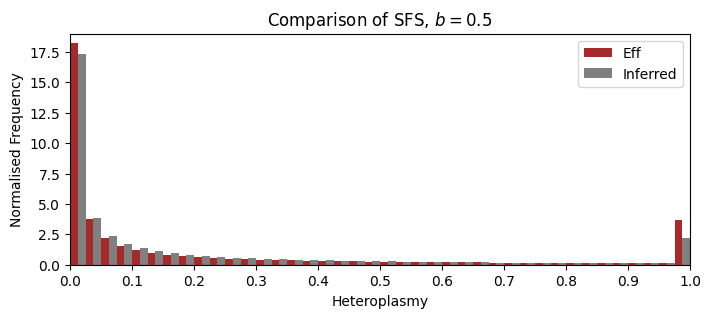

In [100]:
# Define the width for the bars in the histogram
bar_width = 0.025  # The width of your bars

# Calculate the positions of the bin centers
bin_centers = np.arange(0, 1, bar_width) + (bar_width / 2)

averaged_sfs_n[-1] += 0.3
# Create the plot
plt.figure(figsize=(8, 3))
plt.bar(bin_centers - bar_width / 4, averaged_sfs_n, width=bar_width / 2, label='Eff', color='brown', align='center')
plt.bar(bin_centers + bar_width / 4, averaged_sfs, width=bar_width / 2 , label='Inferred', color='gray', align='center')
plt.xlabel('Heteroplasmy')
plt.ylabel('Normalised Frequency')
plt.title(r'Comparison of SFS, $b=0.5$')
plt.legend()
plt.xticks(np.arange(0, 1.1, 0.1))
plt.xlim(0, 1)
plt.ylim(0, 19)  # Adjust y-axis limit if necessary
plt.show()

### Comparison to the equivalent forward Moran process:

In [105]:
# Parameters
t_half = 30  # Half-life of mtDNA in days
mu = 1e-2  # Mutation rate per site per replication
time_stages = [40 * 365, 30 * 365, 20*365, 10 * 365]  # Time of stages in days
pop_sizes = [500, 250, 1000, 500]  # Population sizes for each stage
num_simulations = 500  # Number of simulations to run

In [102]:
# Function to adjust population size - old method commented
# def adjust_population(population, new_size):
#     if new_size > len(population):
#         additional = np.random.choice(population, new_size - len(population), replace=True)
#         population.extend(additional)
#     elif new_size < len(population):
#         remove_indices = np.random.choice(range(len(population)), len(population) - new_size, replace=False)
#         for index in sorted(remove_indices, reverse=True):
#             population.pop(index)
#     return population

def adjust_population(population, new_size):
    if new_size == len(population):
        return population
    else:
        new_population = np.random.choice(population, new_size, replace=True)
        return list(new_population)

In [103]:
# Function to perform a single Moran event
def moran_event(population, mutation_counter, N):
    parent_index = np.random.randint(N)
    if np.random.rand() < mu:
        mutation_counter += 1
        new_mutation = mutation_counter
        offspring_mutations = population[parent_index].copy()
        offspring_mutations.add(new_mutation)
    else:
        offspring_mutations = population[parent_index].copy()
    replace_index = np.random.randint(N)
    population[replace_index] = offspring_mutations
    return population, mutation_counter

In [106]:
# Initialize variables for histograms
all_hist = np.zeros((num_simulations, 40))

for sim in tqdm(range(num_simulations), desc='Running Moran simulations with varying population'):
    population = [set() for _ in range(pop_sizes[0])]
    mutation_counter = 0
    current_time = 0
    stage = 0
    N = pop_sizes[0]

    while stage < len(time_stages):
        Lambda = N * np.log(2) / t_half
        while current_time < sum(time_stages[:stage + 1]):
            time_to_next_event = np.random.exponential(scale=1/Lambda)
            current_time += time_to_next_event
            population, mutation_counter = moran_event(population, mutation_counter, N)

        if stage < len(pop_sizes) - 1:  # Adjust population size if not the last stage
            N = pop_sizes[stage + 1]
            population = adjust_population(population, N)

        stage += 1

    # Count the mutation frequency
    mutation_frequency = {}
    for individual in population:
        for mutation in individual:
            mutation_frequency[mutation] = mutation_frequency.get(mutation, 0) + 1

    heteroplasmy = {mutation: count / N for mutation, count in mutation_frequency.items()}
    heteroplasmy_values = list(heteroplasmy.values())

    bin_edges = np.arange(0, 1.025, 0.025)
    hist, _ = np.histogram(heteroplasmy_values, bins=bin_edges)
    normalized_hist = hist / (sum(hist) * 0.025 + 1e-7)
    all_hist[sim] = normalized_hist

average_hist_forward = np.mean(all_hist, axis=0)

Running Moran simulations with varying population: 100%|██████████| 500/500 [16:08<00:00,  1.94s/it]


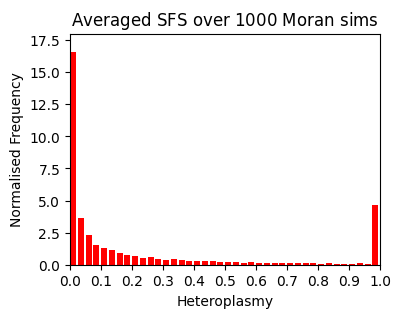

In [107]:
# Plot the average histogram
plt.figure(figsize=(4, 3))
plt.bar(bin_edges[:-1], average_hist_forward, width=0.025*0.8, align='edge', color='red')
plt.xlabel('Heteroplasmy')
plt.ylabel('Normalised Frequency')
plt.title(r'Averaged SFS over $1000$ Moran sims')
plt.xticks(np.arange(0, 1.1, 0.1))
plt.xlim(0, 1)
plt.ylim(0, 18)
plt.show()

In [109]:
N_eff = 1 / ( (40/(100))/(500) + (30/(100))/(250) + (20/(100))/(1000) + (10/(100))/(500))
N_eff

416.66666666666663

In [110]:
a = 1
b = 1
tau_proper_years = 10  # Proper time for tau in years
psi_proper_years = 30 # Proper time for psi in years
phi_proper_years = age - tau_proper_years - psi_proper_years  # Proper time for phi in years
t_half = 30  # Half-life of mtDNA in days
n = int(N_eff)

# Convert proper times to scaled times
tau = proper_to_scaled_time(tau_proper_years, n, t_half)
psi = proper_to_scaled_time(psi_proper_years, n*b, t_half)
phi = proper_to_scaled_time(phi_proper_years, n, t_half)

# 1. Pre-compute e_j_values
e_j_values = precompute_all_e_j_values(n, tau, psi, phi, a, b)

# 2. Pre-compute U_n_j_values
U_n_j_values = [calculate_U_n_j(n, j) for j in range(2, n+1)]

# 3. Pre-compute D_n_j_values
D_n_j_values = [calculate_D_n_j(n, j) for j in range(2, n+1)]

# 4. Pre-compute W_n_b_j_matrix for b from 1 to n-1
W_n_b_j_matrix = [calculate_W_n_b_j(n, b_val) for b_val in range(1, n)]

# 5. Calculate the vector q_n, b for b from 1 to n-1
q_n_b = calculate_q_n_b(n, e_j_values, U_n_j_values, D_n_j_values, W_n_b_j_matrix, tau, psi, phi, absolute=False)

# Convert q_n_b's entries to represent the SFS, scaled up by n
scaled_sfs = np.array([float(val) * n for val in q_n_b])
heteroplasmy_ratios = np.array(range(1, n + 1)) / n

# Define bin edges for plotting with a bin width of 0.05
new_bin_width = 0.025
new_bin_edges = np.arange(0, 1 + new_bin_width, new_bin_width)

# Initialize an array to hold the new averaged frequencies
averaged_sfs_n = np.zeros(len(new_bin_edges) - 1)

# Aggregate the original frequencies into the new bins
for i in range(len(averaged_sfs_n)):
    # Determine the start and end of the current bin
    bin_start = new_bin_edges[i]
    bin_end = new_bin_edges[i + 1]
    
    # Calculate the average frequency for heteroplasmy levels within the current bin
    indices = np.where((heteroplasmy_ratios > bin_start) & (heteroplasmy_ratios <= bin_end))[0]
    averaged_sfs_n[i] = np.mean(scaled_sfs[indices]) if len(indices) > 0 else 0

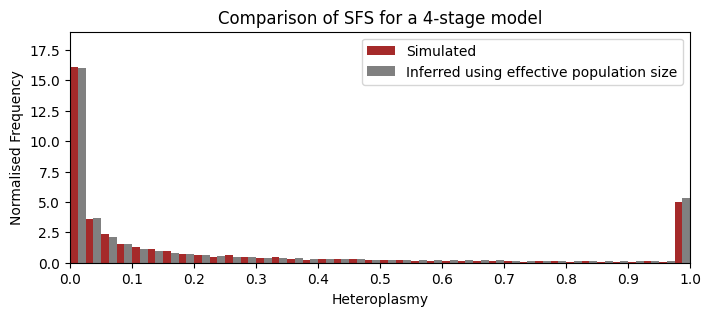

In [117]:
# Define the width for the bars in the histogram
bar_width = 0.025  # The width of your bars

# Calculate the positions of the bin centers
bin_centers = np.arange(0, 1, bar_width) + (bar_width / 2)

# Create the plot
plt.figure(figsize=(8, 3))
plt.bar(bin_centers - bar_width / 4, average_hist_forward, width=bar_width / 2, label='Simulated', color='brown', align='center')
plt.bar(bin_centers + bar_width / 4, averaged_sfs_n, width=bar_width / 2 , label='Inferred using effective population size', color='gray', align='center')
plt.xlabel('Heteroplasmy')
plt.ylabel('Normalised Frequency')
plt.title(r'Comparison of SFS for a 4-stage model')
plt.legend()
plt.xticks(np.arange(0, 1.1, 0.1))
plt.xlim(0, 1)
plt.ylim(0, 19)  # Adjust y-axis limit if necessary
plt.show()

### Varying $b$:

In [15]:
# Parameters
tau_proper_years = 10  # Proper time for tau in years
psi_proper_years = 10  # Proper time for psi in years
phi_proper_years = age - tau_proper_years - psi_proper_years  # Proper time for phi in years
a = 1  # Fixed parameter value
n = n_w * a
t_half = 30  # Half-life of mtDNA in days

In [16]:
# Convert proper times to scaled times
tau_scaled = proper_to_scaled_time(tau_proper_years, n, t_half)
psi_scaled = proper_to_scaled_time(psi_proper_years, n, t_half)
phi_scaled = proper_to_scaled_time(phi_proper_years, n, t_half)

In [17]:
# Pre-compute U, D, and W outside the loop
U_n_j_values = precompute_U_n_j_values(n)
D_n_j_values = precompute_D_n_j_values(n)
W_n_b_j_matrix = [calculate_W_n_b_j(n, b_val) for b_val in range(1, n)]

In [18]:
# b values from 0.05 to 10.05 with a step of 0.025
b_values = np.arange(0.05, 4.05, 0.025)

In [19]:
# Initialize an array to store the homoplasmy rates for each b
homoplasmy_rates = []

# Loop with progress bar
for b in tqdm(b_values, desc='Calculating homoplasmy rates'): 
    psi_scaled = proper_to_scaled_time(psi_proper_years, n*b, t_half)
    # Compute e_j_values for the current b
    e_j_values = precompute_all_e_j_values(n, tau_scaled, psi_scaled, phi_scaled, a, b)
    
    # Compute q_n_b using the pre-computed values
    q_n_b = calculate_q_n_b(n, e_j_values, U_n_j_values, D_n_j_values, W_n_b_j_matrix, tau_scaled, psi_scaled, phi_scaled, absolute=False)
    
    # Extract the last entry for the homoplasmy ratio
    homoplasmy_rate = float(q_n_b[n-1])  # Convert to float for plotting/analysis
    
    # Store the homoplasmy rate
    homoplasmy_rates.append(homoplasmy_rate)

Calculating homoplasmy rates: 100%|██████████| 160/160 [01:35<00:00,  1.67it/s]


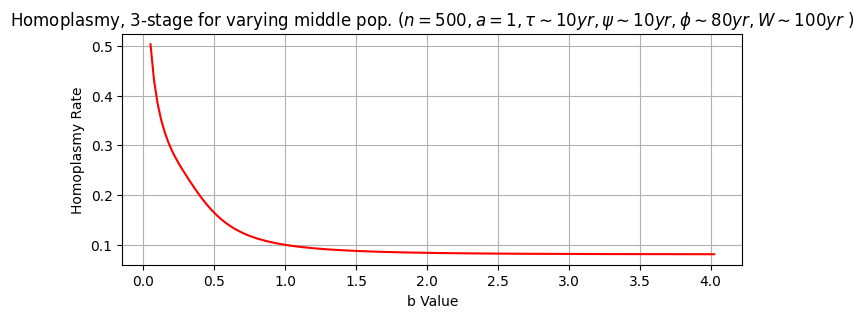

In [20]:
# Plot homoplasmy rates against b values
plt.figure(figsize=(8,3))
plt.plot(b_values, homoplasmy_rates, linestyle='-', color='r')
plt.title(r'Homoplasmy, 3-stage for varying middle pop. ($n = 500, a = 1, \tau \sim 10 yr, \psi \sim 10 yr, \phi \sim 80 yr, W \sim 100 yr$ )')
plt.xlabel('b Value')
plt.ylabel('Homoplasmy Rate')
plt.grid(True)
plt.show()

### More investigations:

In [23]:
# Parameters
tau_proper_years = 10  # Fixed tau in years
a = 1  # Fixed parameter value
n = n_w * a
t_half = 30  # Half-life of mtDNA in days
age = 100  # Total age, used to calculate phi

# b values to iterate over
b_values = [0.1, 0.2, 0.5, 1, 2, 4]

psi_range = range(1, 51)

# Initialize a matrix to store the homoplasmy rates
homoplasmy_rate_matrix = np.zeros((len(b_values), len(psi_range)))

# Loop through each b value
for b_index, b in enumerate(tqdm(b_values, desc='Overall Progress')):
    with tqdm(total=len(psi_range), desc=f'Calculating for b={b}') as pbar:
        for psi_index, psi_proper_years in enumerate(psi_range):
            # Calculate phi based on fixed total age
            phi_proper_years = age - tau_proper_years - psi_proper_years
            
            # Convert proper times to scaled times
            tau_scaled = proper_to_scaled_time(tau_proper_years, n, t_half)
            psi_scaled = proper_to_scaled_time(psi_proper_years, n*b, t_half)
            phi_scaled = proper_to_scaled_time(phi_proper_years, n, t_half)
            
            # Compute e_j_values for the current b
            e_j_values = precompute_all_e_j_values(n, tau_scaled, psi_scaled, phi_scaled, a, b)
            
            # Compute q_n_b using the pre-computed values
            q_n_b = calculate_q_n_b(n, e_j_values, U_n_j_values, D_n_j_values, W_n_b_j_matrix, tau_scaled, psi_scaled, phi_scaled, absolute=True)
            
            # Extract the last entry for the homoplasmy ratio and store it in the matrix
            homoplasmy_rate_matrix[b_index, psi_index] = float(q_n_b[n-1])
            
            pbar.update(1)

Overall Progress: 100%|██████████| 6/6 [04:00<00:00, 40.15s/it]


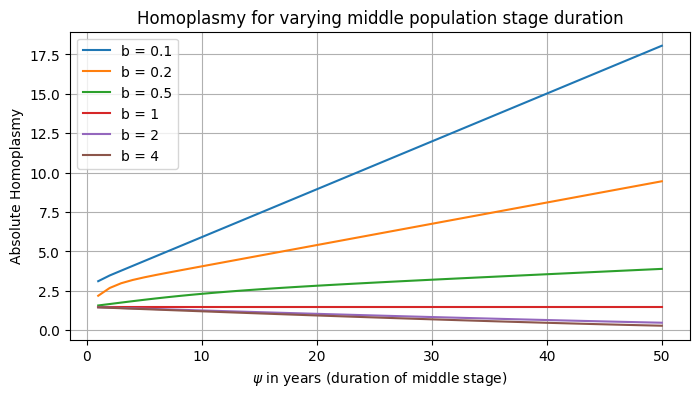

In [24]:
plt.figure(figsize=(8, 4))
for b_index, b in enumerate(b_values):
    plt.plot(psi_range, homoplasmy_rate_matrix[b_index, :],  label=f'b = {b}')

plt.title(r'Homoplasmy for varying middle population stage duration')
plt.xlabel('$\psi$ in years (duration of middle stage)')
plt.ylabel('Absolute Homoplasmy')
plt.legend()
plt.grid(True)
plt.show()

Assume the starting population is still the same as the final population, and the middle population lasts until year 90. Varying the duration of the middle population i.e. how early it starts (from lasting 1 year to 30 years) for different values of $b$ (ratio of middle population size with respect to initial/final).

In [25]:
# Parameters
psi_proper_years = 10  # Fixed psi in years
a = 1  # Fixed parameter value
n = n_w * a
t_half = 30  # Half-life of mtDNA in days
age = 100  # Total age, used to calculate phi

# b values to iterate over
b_values = [0.1, 0.2, 0.5, 1, 2, 4]

tau_range = range(1, 51)

# Initialize a matrix to store the homoplasmy rates
homoplasmy_rate_matrix = np.zeros((len(b_values), len(tau_range)))

# Loop through each b value
for b_index, b in enumerate(tqdm(b_values, desc='Overall Progress')):
    with tqdm(total=len(tau_range), desc=f'Calculating for b={b}') as pbar:
        for tau_index, tau_proper_years in enumerate(tau_range):
            # Calculate phi based on fixed total age
            phi_proper_years = age - tau_proper_years - psi_proper_years
            
            # Convert proper times to scaled times
            tau_scaled = proper_to_scaled_time(tau_proper_years, n, t_half)
            psi_scaled = proper_to_scaled_time(psi_proper_years, n*b, t_half)
            phi_scaled = proper_to_scaled_time(phi_proper_years, n, t_half)
            
            # Compute e_j_values for the current b
            e_j_values = precompute_all_e_j_values(n, tau_scaled, psi_scaled, phi_scaled, a, b)
            
            # Compute q_n_b using the pre-computed values
            q_n_b = calculate_q_n_b(n, e_j_values, U_n_j_values, D_n_j_values, W_n_b_j_matrix, tau_scaled, psi_scaled, phi_scaled, absolute=True)
            
            # Extract the last entry for the homoplasmy ratio and store it in the matrix
            homoplasmy_rate_matrix[b_index, tau_index] = float(q_n_b[n-1])
            
            pbar.update(1)

Overall Progress: 100%|██████████| 6/6 [03:55<00:00, 39.31s/it]


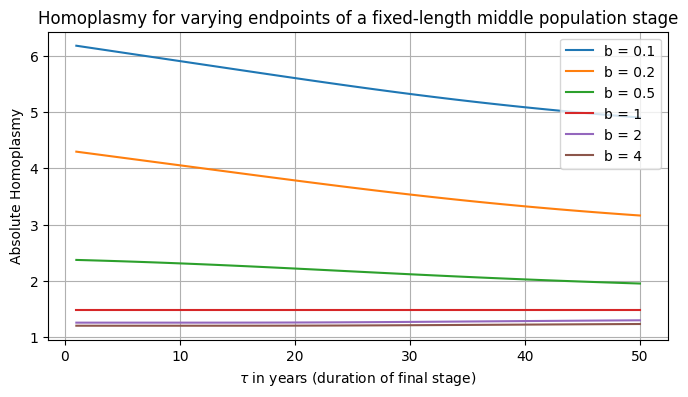

In [26]:
plt.figure(figsize=(8, 4))
for b_index, b in enumerate(b_values):
    plt.plot(tau_range, homoplasmy_rate_matrix[b_index, :],  label=f'b = {b}')

plt.title(r'Homoplasmy for varying endpoints of a fixed-length middle population stage')
plt.xlabel(r'$\tau$ in years (duration of final stage)')
plt.ylabel('Absolute Homoplasmy')
plt.legend()
plt.grid(True)
plt.show()

Assume the starting population is still the same as the final population, and the middle population lasts 10 years. Varying the end time of the middle population (from ending at year 99 to ending at year 70) for different values of $b$ (ratio of middle population size with respect to initial/final).

### Looking into extra lifespan from treatments ending at the same time:

In [13]:
# Baseline parameters
a_baseline = b_baseline = 1
age = 100
t_half = 30  # Half-life of mtDNA in days

# Baseline calculation with no treatment
n_baseline = n_w * a_baseline
U_n_j_values = precompute_U_n_j_values(n_baseline)
D_n_j_values = precompute_D_n_j_values(n_baseline)
W_n_b_j_matrix = precompute_W_n_b_j_matrix(n_baseline)
tau_scaled_baseline = proper_to_scaled_time(age / 3, n_baseline, t_half)  # Arbitrary split for baseline
baseline_e_j_values = precompute_all_e_j_values(n_baseline, tau_scaled_baseline, tau_scaled_baseline, tau_scaled_baseline, a_baseline, b_baseline)
baseline_q_n_b = calculate_q_n_b(n_baseline, baseline_e_j_values, U_n_j_values, D_n_j_values, W_n_b_j_matrix, tau_scaled_baseline, tau_scaled_baseline, tau_scaled_baseline, absolute=True)
baseline_homoplasmy_rate = float(baseline_q_n_b[n_baseline-1])

print(f"Baseline homoplasmy rate: {baseline_homoplasmy_rate}")

Baseline homoplasmy rate: 1.4796668209388153


In [23]:
# Treatment parameters
a_treatment = 1
b_treatment = 2  # Fixed b for treatment
psi_range = range(1, 31)  # Treatment duration from 1 to 50 years
extended_lifespans = []  # To store the results
n = 500

# Loop for varying treatment length (psi)
for psi_proper_years in tqdm(psi_range, desc='Varying treatment length'):
    phi_proper_years = age - psi_proper_years - 10  # Keep phi constant, adjust age with tau
    for tau_proper_years in np.arange(10, 50, 0.1):  # Extended lifespan up to an additional 50 years
        n_treatment = n_w * a_treatment
        tau_scaled = proper_to_scaled_time(tau_proper_years, n_treatment, t_half)
        psi_scaled = proper_to_scaled_time(psi_proper_years, n_treatment*b_treatment, t_half)
        phi_scaled = proper_to_scaled_time(phi_proper_years, n_treatment, t_half)
        
        treatment_e_j_values = precompute_all_e_j_values(n, tau_scaled, psi_scaled, phi_scaled, a_treatment, b_treatment)
        treatment_q_n_b = calculate_q_n_b(n, treatment_e_j_values, U_n_j_values, D_n_j_values, W_n_b_j_matrix, tau_scaled, psi_scaled, phi_scaled, absolute = True)
        treatment_homoplasmy_rate = float(treatment_q_n_b[n_treatment-1])
        
        # Compare treatment homoplasmy rate to baseline
        if treatment_homoplasmy_rate >= baseline_homoplasmy_rate:  # Tolerance for matching rates
            extended_lifespan = tau_proper_years - 10  # Additional years beyond the standard 90 years
            extended_lifespans.append((psi_proper_years, extended_lifespan))
            break

# Convert results to a numpy array for easier analysis
extended_lifespans_np_2 = np.array(extended_lifespans, dtype=[('psi_years', 'f2'), ('extra_lifespan', 'f2')])

Varying treatment length:   0%|          | 0/30 [00:00<?, ?it/s]

Varying treatment length: 100%|██████████| 30/30 [31:59<00:00, 63.97s/it] 


In [18]:
# Treatment parameters
a_treatment = 1
b_treatment = 4  # Fixed b for treatment
psi_range = range(1, 31)  # Treatment duration from 1 to 50 years
extended_lifespans = []  # To store the results
n = 500

# Loop for varying treatment length (psi)
for psi_proper_years in tqdm(psi_range, desc='Varying treatment length'):
    phi_proper_years = age - psi_proper_years - 10  # Keep phi constant, adjust age with tau
    for tau_proper_years in np.arange(10, 50, 0.1):  # Extended lifespan up to an additional 50 years
        n_treatment = n_w * a_treatment
        tau_scaled = proper_to_scaled_time(tau_proper_years, n_treatment, t_half)
        psi_scaled = proper_to_scaled_time(psi_proper_years, n_treatment*b_treatment, t_half)
        phi_scaled = proper_to_scaled_time(phi_proper_years, n_treatment, t_half)
        
        treatment_e_j_values = precompute_all_e_j_values(n, tau_scaled, psi_scaled, phi_scaled, a_treatment, b_treatment)
        treatment_q_n_b = calculate_q_n_b(n, treatment_e_j_values, U_n_j_values, D_n_j_values, W_n_b_j_matrix, tau_scaled, psi_scaled, phi_scaled, absolute = True)
        treatment_homoplasmy_rate = float(treatment_q_n_b[n_treatment-1])
        
        # Compare treatment homoplasmy rate to baseline
        if treatment_homoplasmy_rate >= baseline_homoplasmy_rate:  # Tolerance for matching rates
            extended_lifespan = tau_proper_years - 10  # Additional years beyond the standard 90 years
            extended_lifespans.append((psi_proper_years, extended_lifespan))
            break

# Convert results to a numpy array for easier analysis
extended_lifespans_np_4 = np.array(extended_lifespans, dtype=[('psi_years', 'f2'), ('extra_lifespan', 'f2')])

Varying treatment length: 100%|██████████| 30/30 [43:47<00:00, 87.59s/it] 


In [19]:
# Treatment parameters
a_treatment = 1
b_treatment = 1.5  # Fixed b for treatment
psi_range = range(1, 31)  # Treatment duration from 1 to 50 years
extended_lifespans = []  # To store the results
n = 500

# Loop for varying treatment length (psi)
for psi_proper_years in tqdm(psi_range, desc='Varying treatment length'):
    phi_proper_years = age - psi_proper_years - 10  # Keep phi constant, adjust age with tau
    for tau_proper_years in np.arange(10, 50, 0.1):  # Extended lifespan up to an additional 50 years
        n_treatment = n_w * a_treatment
        tau_scaled = proper_to_scaled_time(tau_proper_years, n_treatment, t_half)
        psi_scaled = proper_to_scaled_time(psi_proper_years, n_treatment*b_treatment, t_half)
        phi_scaled = proper_to_scaled_time(phi_proper_years, n_treatment, t_half)
        
        treatment_e_j_values = precompute_all_e_j_values(n, tau_scaled, psi_scaled, phi_scaled, a_treatment, b_treatment)
        treatment_q_n_b = calculate_q_n_b(n, treatment_e_j_values, U_n_j_values, D_n_j_values, W_n_b_j_matrix, tau_scaled, psi_scaled, phi_scaled, absolute = True)
        treatment_homoplasmy_rate = float(treatment_q_n_b[n_treatment-1])
        
        # Compare treatment homoplasmy rate to baseline
        if treatment_homoplasmy_rate >= baseline_homoplasmy_rate:  # Tolerance for matching rates
            extended_lifespan = tau_proper_years - 10  # Additional years beyond the standard 90 years
            extended_lifespans.append((psi_proper_years, extended_lifespan))
            break

# Convert results to a numpy array for easier analysis
extended_lifespans_np_15 = np.array(extended_lifespans, dtype=[('psi_years', 'f2'), ('extra_lifespan', 'f2')])

Varying treatment length: 100%|██████████| 30/30 [27:50<00:00, 55.67s/it]


In [20]:
# Treatment parameters
a_treatment = 1
b_treatment = 1.2  # Fixed b for treatment
psi_range = range(1, 31)  # Treatment duration from 1 to 50 years
extended_lifespans = []  # To store the results
n = 500

# Loop for varying treatment length (psi)
for psi_proper_years in tqdm(psi_range, desc='Varying treatment length'):
    phi_proper_years = age - psi_proper_years - 10  # Keep phi constant, adjust age with tau
    for tau_proper_years in np.arange(10, 50, 0.1):  # Extended lifespan up to an additional 50 years
        n_treatment = n_w * a_treatment
        tau_scaled = proper_to_scaled_time(tau_proper_years, n_treatment, t_half)
        psi_scaled = proper_to_scaled_time(psi_proper_years, n_treatment*b_treatment, t_half)
        phi_scaled = proper_to_scaled_time(phi_proper_years, n_treatment, t_half)
        
        treatment_e_j_values = precompute_all_e_j_values(n, tau_scaled, psi_scaled, phi_scaled, a_treatment, b_treatment)
        treatment_q_n_b = calculate_q_n_b(n, treatment_e_j_values, U_n_j_values, D_n_j_values, W_n_b_j_matrix, tau_scaled, psi_scaled, phi_scaled, absolute = True)
        treatment_homoplasmy_rate = float(treatment_q_n_b[n_treatment-1])
        
        # Compare treatment homoplasmy rate to baseline
        if treatment_homoplasmy_rate >= baseline_homoplasmy_rate:  # Tolerance for matching rates
            extended_lifespan = tau_proper_years - 10  # Additional years beyond the standard 90 years
            extended_lifespans.append((psi_proper_years, extended_lifespan))
            break

# Convert results to a numpy array for easier analysis
extended_lifespans_np_12 = np.array(extended_lifespans, dtype=[('psi_years', 'f2'), ('extra_lifespan', 'f2')])

Varying treatment length: 100%|██████████| 30/30 [15:04<00:00, 30.16s/it]


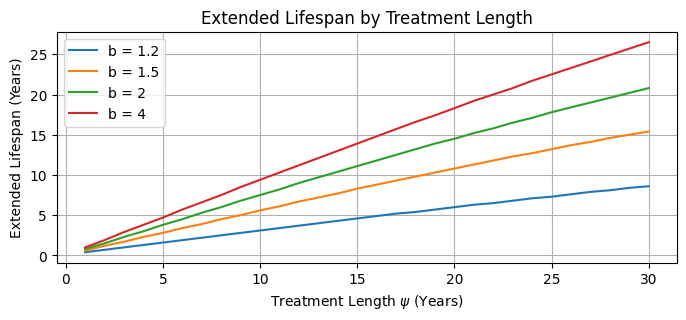

In [120]:
# Plot the results
plt.figure(figsize=(8, 3))
plt.plot(extended_lifespans_np_12['psi_years'], extended_lifespans_np_12['extra_lifespan'], linestyle='-', label = 'b = 1.2')
plt.plot(extended_lifespans_np_15['psi_years'], extended_lifespans_np_15['extra_lifespan'], linestyle='-', label = 'b = 1.5')

plt.plot(extended_lifespans_np_2['psi_years'], extended_lifespans_np_2['extra_lifespan'], linestyle='-', label = 'b = 2')
plt.plot(extended_lifespans_np_4['psi_years'], extended_lifespans_np_4['extra_lifespan'], linestyle='-', label = 'b = 4')

plt.xlabel(r'Treatment Length $\psi$ (Years)')
plt.ylabel('Extended Lifespan (Years)')
plt.title(r'Extended Lifespan by Treatment Length')
plt.grid(True)
plt.legend()
plt.show()

The 'extended lifespan' is the extra number of years it takes for a user that has received a treatment (that increases the middle population size) to reach the same level of relative homoplasmy rate as he would otherwise have achieved without the treatment at 100 years old.

### Looking into extra lifespan from treatments starting at the same time:

In [185]:
# Baseline parameters
a_baseline = b_baseline = 1
age = 100
t_half = 30  # Half-life of mtDNA in days

# Baseline calculation with no treatment
n_baseline = n_w * a_baseline
U_n_j_values = precompute_U_n_j_values(n_baseline)
D_n_j_values = precompute_D_n_j_values(n_baseline)
W_n_b_j_matrix = precompute_W_n_b_j_matrix(n_baseline)
tau_scaled_baseline = proper_to_scaled_time(age / 3, n_baseline, t_half)  # Arbitrary split for baseline
baseline_e_j_values = precompute_all_e_j_values(n_baseline, tau_scaled_baseline, tau_scaled_baseline, tau_scaled_baseline, a_baseline, b_baseline)
baseline_q_n_b = calculate_q_n_b(n_baseline, baseline_e_j_values, U_n_j_values, D_n_j_values, W_n_b_j_matrix, tau_scaled_baseline, tau_scaled_baseline, tau_scaled_baseline, absolute=True)
baseline_homoplasmy_rate = float(baseline_q_n_b[n_baseline-1])

print(f"Baseline homoplasmy rate: {baseline_homoplasmy_rate}")

Baseline homoplasmy rate: 1.4796668209388153


In [190]:
# Treatment parameters
a_treatment = 2
b_treatment = 2  # Fixed b for treatment
phi_range = range(81, 91)
extended_lifespans = []  # To store the results
n_treatment = 500 * a_treatment

U_n_j_values = precompute_U_n_j_values(n_treatment)
D_n_j_values = precompute_D_n_j_values(n_treatment)
W_n_b_j_matrix = precompute_W_n_b_j_matrix(n_treatment)

# Loop for varying treatment length (psi)
for phi_proper_years in tqdm(phi_range, desc='Varying treatment length'):
    psi_proper_years = age - phi_proper_years - 1  # Keep phi constant, adjust age with tau
    for tau_proper_years in np.arange(1, 11, 0.1):  # Extended lifespan up to an additional 50 years
        n_treatment = n_w * a_treatment
        tau_scaled = proper_to_scaled_time(tau_proper_years, 500*a_treatment, t_half)
        psi_scaled = proper_to_scaled_time(psi_proper_years, 500*b_treatment, t_half)
        phi_scaled = proper_to_scaled_time(phi_proper_years, 500, t_half)
        
        treatment_e_j_values = precompute_all_e_j_values(n_treatment, tau_scaled, psi_scaled, phi_scaled, a_treatment, b_treatment)
        treatment_q_n_b = calculate_q_n_b(n_treatment, treatment_e_j_values, U_n_j_values, D_n_j_values, W_n_b_j_matrix, tau_scaled, psi_scaled, phi_scaled, absolute = True)
        treatment_homoplasmy_rate = float(treatment_q_n_b[n_treatment-1])
        print(treatment_homoplasmy_rate)
        
        # Compare treatment homoplasmy rate to baseline
        if treatment_homoplasmy_rate >= baseline_homoplasmy_rate:  # Tolerance for matching rates
            extended_lifespan = tau_proper_years - 1  # Additional years beyond the standard 90 years
            extended_lifespans.append((psi_proper_years, extended_lifespan))
            break

# Convert results to a numpy array for easier analysis
extended_lifespans_np_2 = np.array(extended_lifespans, dtype=[('phi_years', 'f2'), ('extra_lifespan', 'f2')])

Varying treatment length:  10%|█         | 1/10 [00:02<00:18,  2.03s/it]

1.8982185538892453


Varying treatment length:  20%|██        | 2/10 [00:04<00:16,  2.04s/it]

1.923291357875296


Varying treatment length:  30%|███       | 3/10 [00:06<00:14,  2.04s/it]

1.9483754257563646


Varying treatment length:  40%|████      | 4/10 [00:08<00:12,  2.03s/it]

1.9734701706518865


Varying treatment length:  50%|█████     | 5/10 [00:10<00:10,  2.03s/it]

1.9985750493089354


Varying treatment length:  60%|██████    | 6/10 [00:12<00:08,  2.03s/it]

2.023689553893314


Varying treatment length:  70%|███████   | 7/10 [00:14<00:06,  2.02s/it]

2.048813206171842


Varying treatment length:  80%|████████  | 8/10 [00:16<00:04,  2.02s/it]

2.0739455536143807


Varying treatment length:  90%|█████████ | 9/10 [00:18<00:02,  2.02s/it]

2.0990861668532417


Varying treatment length: 100%|██████████| 10/10 [00:20<00:00,  2.03s/it]

2.1242346379776604


In [184]:
extended_lifespans_np_2

array([(29., 1.), (61., 1.), (29., 1.), (61., 1.), (29., 1.), (61., 1.),
       (29., 1.), (61., 1.), (29., 1.), (61., 1.)],
      dtype=[('phi_years', '<f2'), ('extra_lifespan', '<f2')])

### Grid scan:

In [27]:
# Parameters
a = 1  # Fixed parameter value
b = 2  # Fixed parameter value
n = a * n_w
t_half = 30  # Half-life of mtDNA in days

# Range of tau and psi values in years
tau_psi_range = range(4, 22, 1)

# Initialize a matrix to store the homoplasmy rates
homoplasmy_rate_matrix = np.zeros((len(tau_psi_range), len(tau_psi_range)))

# Pre-compute U, D, and W
U_n_j_values = precompute_U_n_j_values(n)
D_n_j_values = precompute_D_n_j_values(n)
W_n_b_j_matrix = [calculate_W_n_b_j(n, b_val) for b_val in range(1, n)]

# Iterate over tau and psi values
for i, tau_proper_years in enumerate(tqdm(tau_psi_range, desc='Tau values')):
    for j, psi_proper_years in enumerate(tau_psi_range):
        # Calculate phi to ensure tau + psi + phi = 100
        phi_proper_years = 100 - tau_proper_years - psi_proper_years

        # Convert proper times to scaled times
        tau_scaled = proper_to_scaled_time(tau_proper_years, n, t_half)
        psi_scaled = proper_to_scaled_time(psi_proper_years, n*b, t_half)
        phi_scaled = proper_to_scaled_time(phi_proper_years, n, t_half)
        
        # Compute e_j_values for the current tau, psi, and phi
        e_j_values = precompute_all_e_j_values(n, tau_scaled, psi_scaled, phi_scaled, a, b)
        
        # Compute q_n_b using the pre-computed values
        q_n_b = calculate_q_n_b(n, e_j_values, U_n_j_values, D_n_j_values, W_n_b_j_matrix, tau_scaled, psi_scaled, phi_scaled, absolute=True)
        
        # Extract the last entry for the homoplasmy ratio
        homoplasmy_rate = float(q_n_b[n-1])  # Convert to float
        
        # Store the homoplasmy rate in the matrix
        homoplasmy_rate_matrix[i][j] = homoplasmy_rate

Tau values: 100%|██████████| 18/18 [03:40<00:00, 12.24s/it]


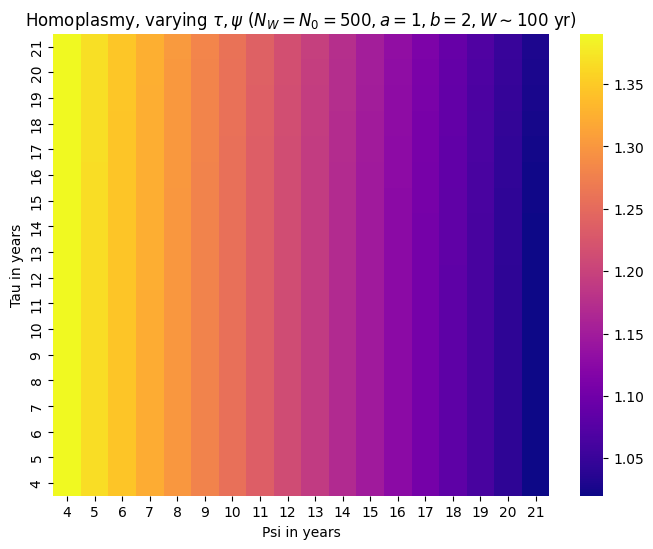

In [28]:
# Convert tau_psi_range from range to list for plotting purposes
tau_psi_range_list = list(tau_psi_range)

# Create a figure and axis for the heatmap
plt.figure(figsize=(8, 6))

# Create the heatmap
flipped_homoplasmy_rate_matrix = np.flipud(homoplasmy_rate_matrix)
sns.heatmap((flipped_homoplasmy_rate_matrix), xticklabels=tau_psi_range_list, yticklabels=tau_psi_range_list[::-1], annot=False, fmt=".4f", cmap = 'plasma')

# Add labels and title
plt.xlabel('Psi in years')
plt.ylabel('Tau in years')
plt.title(r'Homoplasmy, varying $\tau, \psi$ ($N_W = N_0 = 500, a = 1, b = 2, W \sim 100$ yr)')

# Show the plot
plt.show()

In [29]:
# Parameters
a = 1  # Fixed parameter value
b = 4  # Fixed parameter value
n = a * n_w
t_half = 30  # Half-life of mtDNA in days

# Range of tau and psi values in years
tau_psi_range = range(4, 22, 1)

# Initialize a matrix to store the homoplasmy rates
homoplasmy_rate_matrix = np.zeros((len(tau_psi_range), len(tau_psi_range)))

# Pre-compute U, D, and W
U_n_j_values = precompute_U_n_j_values(n)
D_n_j_values = precompute_D_n_j_values(n)
W_n_b_j_matrix = [calculate_W_n_b_j(n, b_val) for b_val in range(1, n)]

# Iterate over tau and psi values
for i, tau_proper_years in enumerate(tqdm(tau_psi_range, desc='Tau values')):
    for j, psi_proper_years in enumerate(tau_psi_range):
        # Calculate phi to ensure tau + psi + phi = 100
        phi_proper_years = 100 - tau_proper_years - psi_proper_years

        # Convert proper times to scaled times
        tau_scaled = proper_to_scaled_time(tau_proper_years, n, t_half)
        psi_scaled = proper_to_scaled_time(psi_proper_years, n*b, t_half)
        phi_scaled = proper_to_scaled_time(phi_proper_years, n, t_half)
        
        # Compute e_j_values for the current tau, psi, and phi
        e_j_values = precompute_all_e_j_values(n, tau_scaled, psi_scaled, phi_scaled, a, b)
        
        # Compute q_n_b using the pre-computed values
        q_n_b = calculate_q_n_b(n, e_j_values, U_n_j_values, D_n_j_values, W_n_b_j_matrix, tau_scaled, psi_scaled, phi_scaled, absolute = True)
        
        # Extract the last entry for the homoplasmy ratio
        homoplasmy_rate = float(q_n_b[n-1])  # Convert to float
        
        # Store the homoplasmy rate in the matrix
        homoplasmy_rate_matrix[i][j] = homoplasmy_rate

# homoplasmy_rate_matrix now contains the homoplasmy rates for each pair of tau and psi values


Tau values: 100%|██████████| 18/18 [03:05<00:00, 10.30s/it]


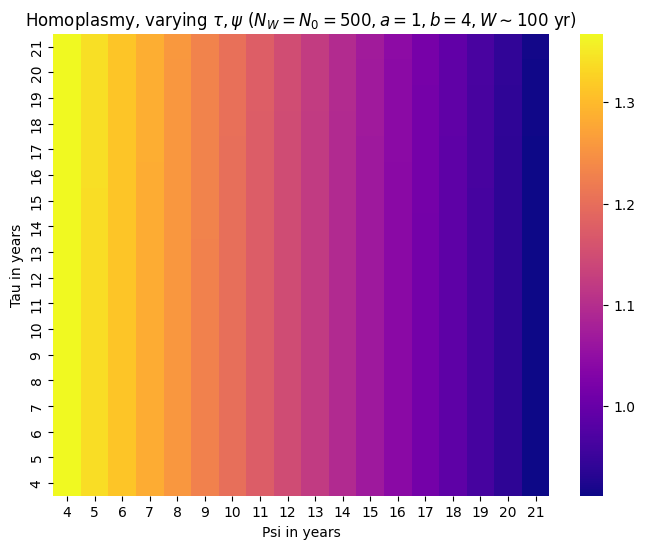

In [30]:
# Convert tau_psi_range from range to list for plotting purposes
tau_psi_range_list = list(tau_psi_range)

# Create a figure and axis for the heatmap
plt.figure(figsize=(8, 6))

# Create the heatmap
flipped_homoplasmy_rate_matrix = np.flipud(homoplasmy_rate_matrix)
sns.heatmap((flipped_homoplasmy_rate_matrix), xticklabels=tau_psi_range_list, yticklabels=tau_psi_range_list[::-1], annot=False, fmt=".4f", cmap = 'plasma')

# Add labels and title
plt.xlabel('Psi in years')
plt.ylabel('Tau in years')
plt.title(r'Homoplasmy, varying $\tau, \psi$ ($N_W = N_0 = 500, a = 1, b = 4, W \sim 100$ yr)')

# Show the plot
plt.show()

In [31]:
# Parameters
a = 1  # Fixed parameter value
b = 0.5  # Fixed parameter value
n = a * n_w
t_half = 30  # Half-life of mtDNA in days

# Range of tau and psi values in years
tau_psi_range = range(4, 22, 1)

# Initialize a matrix to store the homoplasmy rates
homoplasmy_rate_matrix = np.zeros((len(tau_psi_range), len(tau_psi_range)))

# Pre-compute U, D, and W
U_n_j_values = precompute_U_n_j_values(n)
D_n_j_values = precompute_D_n_j_values(n)
W_n_b_j_matrix = [calculate_W_n_b_j(n, b_val) for b_val in range(1, n)]

# Iterate over tau and psi values
for i, tau_proper_years in enumerate(tqdm(tau_psi_range, desc='Tau values')):
    for j, psi_proper_years in enumerate(tau_psi_range):
        # Calculate phi to ensure tau + psi + phi = 100
        phi_proper_years = 100 - tau_proper_years - psi_proper_years

        # Convert proper times to scaled times
        tau_scaled = proper_to_scaled_time(tau_proper_years, n, t_half)
        psi_scaled = proper_to_scaled_time(psi_proper_years, n*b, t_half)
        phi_scaled = proper_to_scaled_time(phi_proper_years, n, t_half)
        
        # Compute e_j_values for the current tau, psi, and phi
        e_j_values = precompute_all_e_j_values(n, tau_scaled, psi_scaled, phi_scaled, a, b)
        
        # Compute q_n_b using the pre-computed values
        q_n_b = calculate_q_n_b(n, e_j_values, U_n_j_values, D_n_j_values, W_n_b_j_matrix, tau_scaled, psi_scaled, phi_scaled, absolute = True)
        
        # Extract the last entry for the homoplasmy ratio
        homoplasmy_rate = float(q_n_b[n-1])  # Convert to float
        
        # Store the homoplasmy rate in the matrix
        homoplasmy_rate_matrix[i][j] = homoplasmy_rate

Tau values: 100%|██████████| 18/18 [03:04<00:00, 10.22s/it]


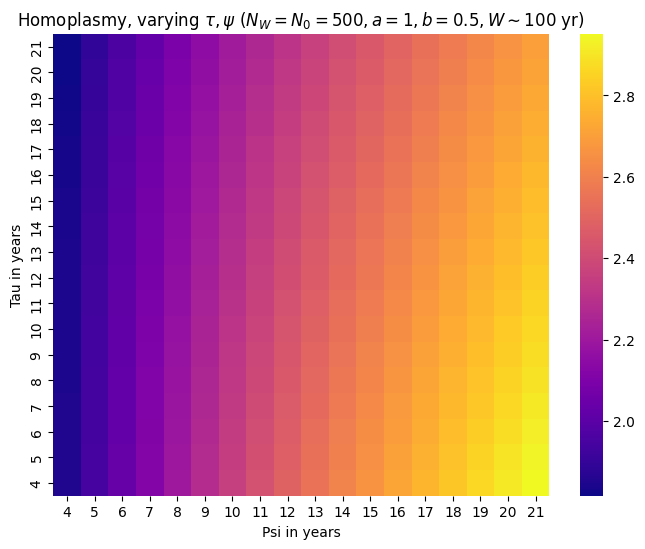

In [32]:
# Convert tau_psi_range from range to list for plotting purposes
tau_psi_range_list = list(tau_psi_range)

# Create a figure and axis for the heatmap
plt.figure(figsize=(8, 6))

# Create the heatmap
flipped_homoplasmy_rate_matrix = np.flipud(homoplasmy_rate_matrix)
sns.heatmap((flipped_homoplasmy_rate_matrix), xticklabels=tau_psi_range_list, yticklabels=tau_psi_range_list[::-1], annot=False, fmt=".4f", cmap = 'plasma')

# Add labels and title
plt.xlabel('Psi in years')
plt.ylabel('Tau in years')
plt.title(r'Homoplasmy, varying $\tau, \psi$ ($N_W = N_0 = 500, a = 1, b = 0.5, W \sim 100$ yr)')

# Show the plot
plt.show()

In [33]:
# Parameters
a = 1  # Fixed parameter value
b = 0.2  # Fixed parameter value
n = a * n_w
t_half = 30  # Half-life of mtDNA in days

# Range of tau and psi values in years
tau_psi_range = range(4, 22, 1)

# Initialize a matrix to store the homoplasmy rates
homoplasmy_rate_matrix = np.zeros((len(tau_psi_range), len(tau_psi_range)))

# Pre-compute U, D, and W
U_n_j_values = precompute_U_n_j_values(n)
D_n_j_values = precompute_D_n_j_values(n)
W_n_b_j_matrix = [calculate_W_n_b_j(n, b_val) for b_val in range(1, n)]

# Iterate over tau and psi values
for i, tau_proper_years in enumerate(tqdm(tau_psi_range, desc='Tau values')):
    for j, psi_proper_years in enumerate(tau_psi_range):
        # Calculate phi to ensure tau + psi + phi = 100
        phi_proper_years = 100 - tau_proper_years - psi_proper_years

        # Convert proper times to scaled times
        tau_scaled = proper_to_scaled_time(tau_proper_years, n, t_half)
        psi_scaled = proper_to_scaled_time(psi_proper_years, n*b, t_half)
        phi_scaled = proper_to_scaled_time(phi_proper_years, n, t_half)
        
        # Compute e_j_values for the current tau, psi, and phi
        e_j_values = precompute_all_e_j_values(n, tau_scaled, psi_scaled, phi_scaled, a, b)
        
        # Compute q_n_b using the pre-computed values
        q_n_b = calculate_q_n_b(n, e_j_values, U_n_j_values, D_n_j_values, W_n_b_j_matrix, tau_scaled, psi_scaled, phi_scaled, absolute = True)
        
        # Extract the last entry for the homoplasmy ratio
        homoplasmy_rate = float(q_n_b[n-1])  # Convert to float
        
        # Store the homoplasmy rate in the matrix
        homoplasmy_rate_matrix[i][j] = homoplasmy_rate

Tau values: 100%|██████████| 18/18 [03:02<00:00, 10.11s/it]


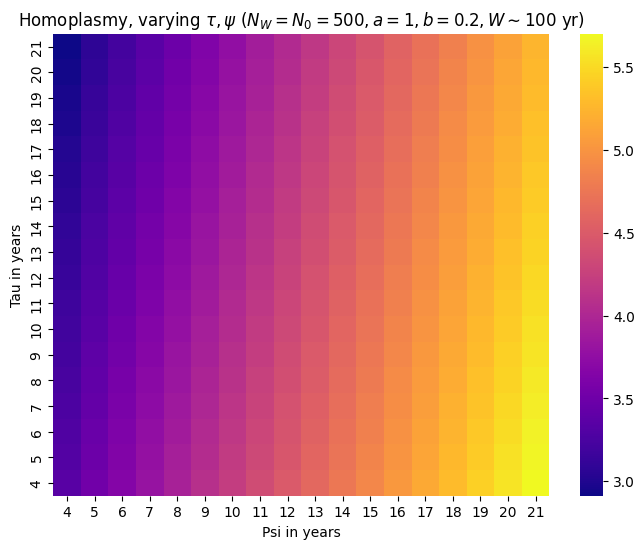

In [34]:
# Convert tau_psi_range from range to list for plotting purposes
tau_psi_range_list = list(tau_psi_range)

# Create a figure and axis for the heatmap
plt.figure(figsize=(8, 6))

# Create the heatmap
flipped_homoplasmy_rate_matrix = np.flipud(homoplasmy_rate_matrix)
sns.heatmap((flipped_homoplasmy_rate_matrix), xticklabels=tau_psi_range_list, yticklabels=tau_psi_range_list[::-1], annot=False, fmt=".4f", cmap = 'plasma')

# Add labels and title
plt.xlabel('Psi in years')
plt.ylabel('Tau in years')
plt.title(r'Homoplasmy, varying $\tau, \psi$ ($N_W = N_0 = 500, a = 1, b = 0.2, W \sim 100$ yr)')

# Show the plot
plt.show()